STRR for French (Qwen2.5-72B): 28.91% | English: 87.86%
STRR for German (Qwen2.5-72B): 16.31% | English: 87.61%
STRR for Italian (Qwen2.5-72B): 15.31% | English: 87.87%
STRR for Spanish (Qwen2.5-72B): 16.56% | English: 87.65%
STRR for Hindi (Qwen2.5-72B): 0.32% | English: 87.88%
STRR for Chinese (Qwen2.5-72B): 97.65% | English: 82.94%


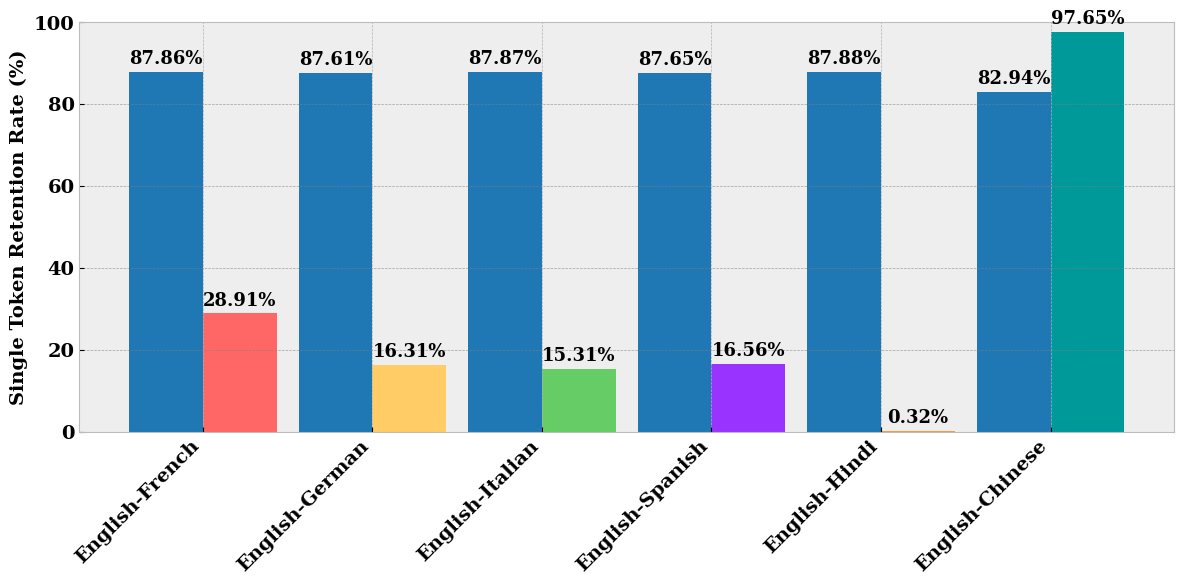

In [ ]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer

def load_json_file(directory, filename):
    """Loads a JSON file from the given directory."""
    file_path = os.path.join(directory, filename)
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)
    return data

def filter_single_word_entries(data, lang_key):
    """Removes entries where either the given language or English word has multiple words."""
    return [entry for entry in data if " " not in entry[lang_key] and " " not in entry["english"]]

def calculate_strr(entries, tokenizer, lang_key):
    """Calculates the Single Token Retention Rate (STRR) for a given tokenizer."""
    single_token_count_lang = sum(1 for entry in entries if len(tokenizer.tokenize(entry[lang_key])) == 1)
    strr_lang = (single_token_count_lang / len(entries)) * 100 if entries else 0

    single_token_count_english = sum(1 for entry in entries if len(tokenizer.tokenize(entry["english"])) == 1)
    strr_english = (single_token_count_english / len(entries)) * 100 if entries else 0

    return strr_lang, strr_english

def plot_strr(results):
    """Plots the STRR results in an academic-style visualization without legends,
    with centered, large, and bold percentage annotations, bold larger axis texts,
    and artificial spacing between bar groups."""
    labels = [f"English-{lang.capitalize()}" for lang in results.keys()]
    lang_values = [results[lang][0] for lang in results.keys()]
    english_values = [results[lang][1] for lang in results.keys()]

    # Use a spacing factor to add extra space between bar groups.
    spacing_factor = 2.0
    x = np.arange(len(labels)) * spacing_factor  # positions for each group
    width = 0.87  # increased width for the bars

    colors = {
        "french": "#ff6666",
        "german": "#ffcc66",
        "italian": "#66cc66",
        "spanish": "#9933ff",
        "hindi": "#ff9933",
        "chinese": "#009999"
    }

    # Fallback mechanism to choose an available style.
    available_styles = plt.style.available
    for style_name in ['seaborn-whitegrid', 'seaborn', 'bmh']:
        if style_name in available_styles:
            plt.style.use(style_name)
            break
    else:
        plt.style.use('default')

    # Update font sizes and styles.
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 12,
        "axes.labelsize": 16,
        "axes.titlesize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14
    })

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, english_values, width, color="#1f77b4")
    bars2 = ax.bar(x + width/2, lang_values, width, color=[colors[lang] for lang in results.keys()])

    # Add gridlines for readability.
    ax.yaxis.grid(True, linestyle="--", linewidth=0.5, color='gray', alpha=0.7)

    # Set axis labels with bold, larger font.
    ax.set_ylabel("Single Token Retention Rate (%)", fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=14, fontweight='bold')

    # Make y-tick labels bold.
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontsize(14)

    # Set Y-axis limit so that 100 is visible.
    ax.set_ylim(0, 100)

    # Annotate each bar with its corresponding value (large and bold).
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),  # slight vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=13, fontweight='bold')

    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=13, fontweight='bold')

    fig.tight_layout()
    plt.show()


def main(directory):
    """Main function to compute and visualize STRR across six languages using the Qwen2.5-72B model."""
    tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-72B-Instruct")

    language_files = {
        "french": "french_english_words.json",
        "german": "german_english_words.json",
        "italian": "italian_english_words.json",
        "spanish": "spanish_english_words.json",
        "hindi": "hindi_english_words.json",
        "chinese": "chinese_english_words.json"
    }

    results = {}
    for lang, filename in language_files.items():
        data = load_json_file(directory, filename)
        filtered_data = filter_single_word_entries(data, lang)
        strr_lang, strr_english = calculate_strr(filtered_data, tokenizer, lang)
        results[lang] = (strr_lang, strr_english)
        print(f"STRR for {lang.capitalize()} (Qwen2.5-72B): {strr_lang:.2f}% | English: {strr_english:.2f}%")

    plot_strr(results)

# Example usage
if __name__ == "__main__":
    main("../data/")
